In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x587ca000 @  0x7fb7b1c452a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import torch

Autograd is a package which is used for automatic differentiation. It requires minimal changes to the existing code - you only need to declare Tensors for which gradients should be computed with the requires_grad=True keyword.

CODING A NEURAL NETWORK IN PYTORCH

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
  def __init__(self):
    
    super(Net,self).__init__()

    self.conv1 = nn.Conv2d(3,6,5)
    self.conv2 = nn.Conv2d(6,16,5)

    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1,self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x= self.fc3(x)
    
    return x
  
  def num_flat_features(self,x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
     
    return num_features


In [14]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


The learnable parametres of the model are returned by net.paramters()

In [15]:
params = list(net.parameters())
print(len(params))

10


Lets try out a simple example of giving this network and input of 32x32

In [16]:
inp = torch.randn(1,1,32,32)
out = net(inp)
print(out)

tensor([[-0.0135,  0.0127, -0.1135, -0.0360,  0.1042, -0.1014,  0.0804, -0.0361,
         -0.1024, -0.0296]], grad_fn=<ThAddmmBackward>)


Zero the gradient buffers of all parameters and backprops with random gradients:

In [0]:
net.zero_grad()
out.backward(torch.randn(1,10))

In [20]:
out.size()

output = net(inp)
target = torch.randn(10)
target = target.view(1,-1)
criterion = nn.MSELoss()

loss = criterion(output,target)
print(loss)

tensor(1.1861, grad_fn=<MseLossBackward>)


To backpropagate the error all we have to do is to loss.backward(). You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

Now we shall call loss.backward(), and have a look at conv1’s bias gradients before and after the backward.

In [21]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0002,  0.0212, -0.0317, -0.0205, -0.0077, -0.0024])


The weight update is done by the optimizer and it is done easily by pytorch by using optimizer.step function before we zero the gradient buffers

In [0]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers

output = net(inp)
loss = criterion(output, target)
loss.backward()

optimizer.step()    # Does the update

**Importing CIFAR10 Dataset and using that data in the network**

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [27]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_cifar = Net()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001, momentum=0.9)

In [40]:
for epoch in range(3):
  
  run_loss = 0 
  for i,data in enumerate(trainloader,0):
    
    inputs, labels = data
    
    optimizer.zero_grad()
    
    outputs = net_cifar(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    
    run_loss = loss.item()
    
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, run_loss / 2000))
      run_loss = 0.0

print("Finished Training")

[1,  2000] loss: 0.001
[1,  4000] loss: 0.001
[1,  6000] loss: 0.001
[1,  8000] loss: 0.001
[1, 10000] loss: 0.001
[1, 12000] loss: 0.001
[2,  2000] loss: 0.001
[2,  4000] loss: 0.001
[2,  6000] loss: 0.001
[2,  8000] loss: 0.001
[2, 10000] loss: 0.001
[2, 12000] loss: 0.001
[3,  2000] loss: 0.001
[3,  4000] loss: 0.001
[3,  6000] loss: 0.001
[3,  8000] loss: 0.001
[3, 10000] loss: 0.001
[3, 12000] loss: 0.001
Finished Training


GroundTruth:    cat  ship  ship plane


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe9b02bc780>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

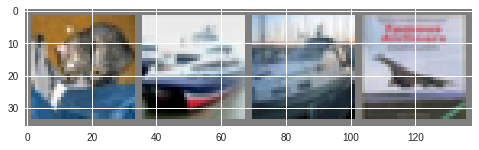

In [44]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(testloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [46]:
output = net_cifar(images)
print(output)

tensor([[-0.0676, -0.0416,  0.1033,  0.0125, -0.1325, -0.0258, -0.0829,  0.0283,
          0.0391, -0.0584],
        [-0.0728, -0.0600,  0.1034,  0.0217, -0.1435, -0.0324, -0.0611,  0.0354,
          0.0217, -0.0417],
        [-0.0724, -0.0520,  0.1027,  0.0160, -0.1324, -0.0337, -0.0691,  0.0322,
          0.0251, -0.0516],
        [-0.0709, -0.0523,  0.0930,  0.0114, -0.1391, -0.0375, -0.0701,  0.0322,
          0.0250, -0.0527]], grad_fn=<ThAddmmBackward>)


In [47]:
_, predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:   bird  bird  bird  bird
